In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai as ai
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image, ImageDraw
import shutil
import requests, zipfile, io
import os
from tqdm import tqdm
import dropbox

## Prepare data

#### Paths

In [3]:
path = Path("/storage/capstone/")
color = 'color'
grayscale = 'grayscale'
colorized = 'colorized'
path_color = path/color
path_gray = path/grayscale
path_gen = path/colorized

if not path_color.exists():
    path_color.mkdir(parents=True)
if not path_gray.exists():
    path_gray.mkdir(parents=True)

path.ls()

[PosixPath('/storage/capstone/grayscale'),
 PosixPath('/storage/capstone/WGU_Capstone.ipynb'),
 PosixPath('/storage/capstone/color'),
 PosixPath('/storage/capstone/colorized'),
 PosixPath('/storage/capstone/WGU_Capstone-MSE.ipynb'),
 PosixPath('/storage/capstone/models'),
 PosixPath('/storage/capstone/.ipynb_checkpoints')]

#### Download data

In [4]:
def download_zip(url, path, fn, chunk_size=128):
    r = requests.get(url, stream=True)
    if r.ok:
        with open(path/fn, 'wb') as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                f.write(chunk)
    else:
        print("request failed")

In [5]:
# download 2017 coco data from http://cocodataset.org/#download
#url = "http://images.cocodataset.org/zips/train2017.zip"
#zip_fn = 'coco.zip'
#download_zip(url, path_color, zip_fn, 1024*1024*100)

In [6]:
# unzip file
#with zipfile.ZipFile(path_color/zip_fn) as z:
#    z.extractall(path_color)

In [7]:
# move images from extract folder to parent folder
#for fp in (path_color/'train2017').ls():
#    shutil.move(fp, path_color/fp.name)

In [8]:
#os.remove(path_color/zip_fn)

#### Make grayscale copies of images

In [9]:
def bnw(fn, i, dest):
    try:
        im = Image.open(fn)
        im.verify()
    except:
        return
    im = Image.open(fn)
    im = im.convert('L')
    im.save(dest/fn.name, quality=100)

In [10]:
# save data to storage (color and grayscale copies)
#il = ImageList.from_folder(path_color)
#ai.core.parallel(partial(bnw, dest=path_gray), il.items)

#### Set up generator data

In [11]:
def get_generator_data(bs, size, p=1.):
    # data source
    label_func = lambda x : path_color/x.name
    src = (ImageImageList
           .from_folder(path_gray).use_partial_data(p)
           .split_by_rand_pct(0.1)
           .label_from_func(label_func))
    # data bunch
    data = src.transform(tfms=get_transforms(), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats, do_y=True)
    data.c = 3
    return data

#### Set up critic data

In [12]:
# used to save predictions from generator
def save_preds(loader, learner, dest):
    if not dest.exists():
        dest.mkdir(parents=True) 
    i=0
    images = loader.dataset.items
    for batch in loader:
        preds = learner.pred_batch(batch=batch, reconstruct=True)
        for p in preds:
            p.save(dest/images[i].name)
            i += 1

In [13]:
def get_critic_data(classes, bs, size):
    # data source
    src = (ImageList
           .from_folder(path, include=classes)
           .split_by_rand_pct(0.1)
           .label_from_folder(classes=classes))
    # data bunch
    data = src.transform(tfms=get_transforms(), size=size).databunch(bs=bs).normalize(imagenet_stats)
    data.c = 3
    return data

#### Set data parameters

In [14]:
bs = 48
size = 128

## Set up models

In [15]:
arch = models.resnet34
loss_gen = MSELossFlat()
wd = 1e-3
def get_generator(data_gen):
    return unet_learner(data_gen, arch, loss_func=loss_gen, 
                        wd=wd, blur=True, norm_type=NormType.Weight, 
                        self_attention=True)

In [16]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())
def get_critic(data_crit, metrics):
    return Learner(data_crit, gan_critic(), metrics=metrics, 
                   loss_func=loss_crit, wd=wd)

## Pre-train generative model

In [ ]:
data_gen = get_generator_data(bs, size)
data_gen.show_batch(ds_type=DatasetType.Train, rows=1)

In [18]:
generator = get_generator(data_gen)

In [19]:
generator.fit_one_cycle(3, 1e-3)

In [20]:
generator.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


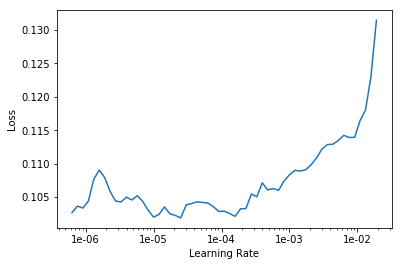

In [21]:
generator.lr_find()
generator.recorder.plot()

In [22]:
generator.fit_one_cycle(6, slice(1e-6,1e-4))

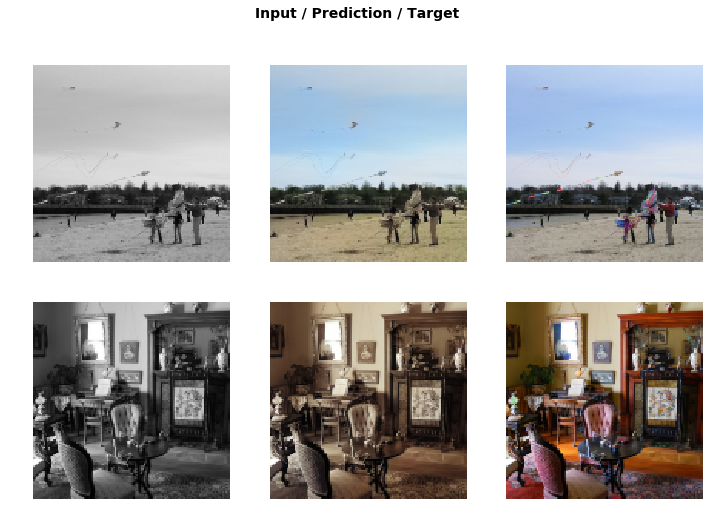

In [23]:
generator.show_results(rows=2)

In [24]:
generator.save('gen-pre')

#### Save predictions

In [25]:
save_preds(data_gen.fix_dl, generator, path_gen)
generator = None
gc.collect()

17935

## Pre-train critic

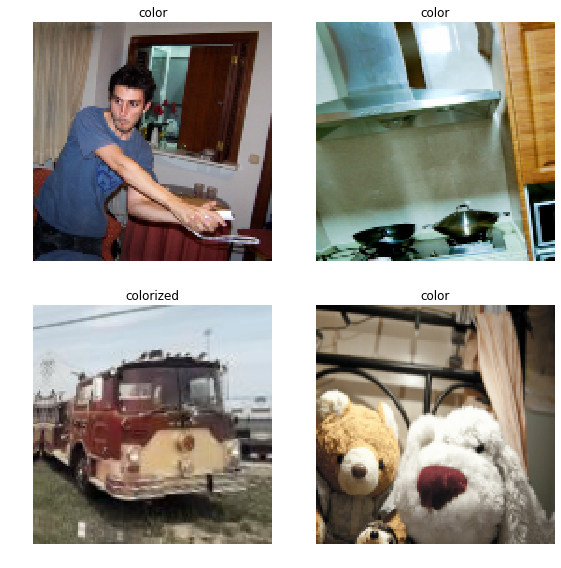

In [17]:
data_crit = get_critic_data([colorized, color], bs=bs, size=size)
data_crit.show_batch(ds_type=DatasetType.Train, rows=2)

In [18]:
critic = get_critic(data_crit, accuracy_thresh_expand)

In [19]:
critic.fit_one_cycle(6, 1e-3)

In [20]:
critic.save('critic-pre')
critic = None
gc.collect()

8015

## GAN

In [17]:
def refresh_gan(version, crit_thresh=0.65, loss_weights=(1.,50.), bs=48, size=128, p=1.):       
    data_gen = get_generator_data(bs, size, p)
    data_crit = get_critic_data([grayscale, color], bs=bs, size=size)
    generator = get_generator(data_gen)
    critic = get_critic(data_crit, metrics=None)
    switcher = partial(AdaptiveGANSwitcher, critic_thresh=crit_thresh)
    if version == 'pre':
        generator.load('gen-pre')
        critic.load('critic-pre')
        return GANLearner.from_learners(generator, critic, weights_gen=loss_weights, 
                                        show_img=True, switcher=switcher,
                                        opt_func=optim.Adam, wd=wd)
    return GANLearner.from_learners(generator, critic, weights_gen=loss_weights, 
                                    show_img=True, switcher=switcher,
                                    opt_func=optim.Adam, wd=wd).load(version)

In [18]:
lr = 1e-4

In [19]:
learn = refresh_gan('pre')
gc.collect()
learn.fit(5, lr)

KeyboardInterrupt: 

In [21]:
learn.save('gan-128-5')

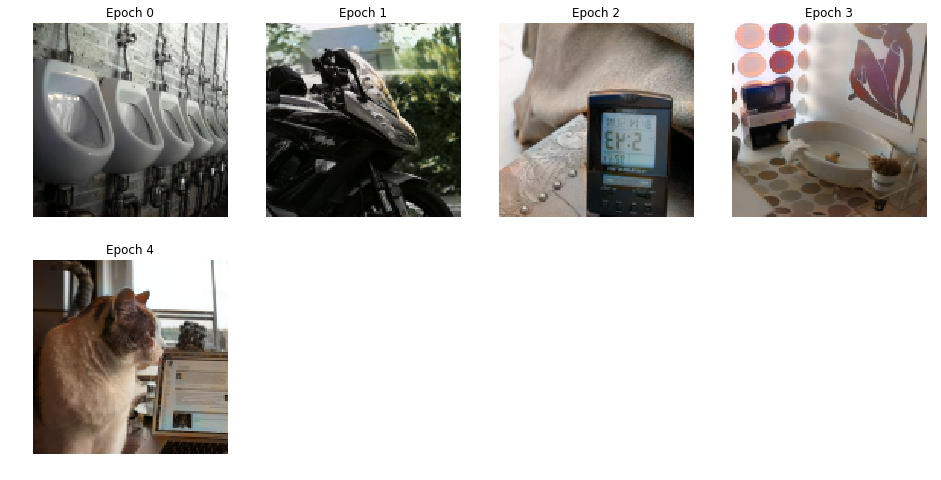

In [20]:
learn = refresh_gan('gan-128-5')
gc.collect()
learn.fit(5, lr)

In [21]:
learn.save('gan-128-10')

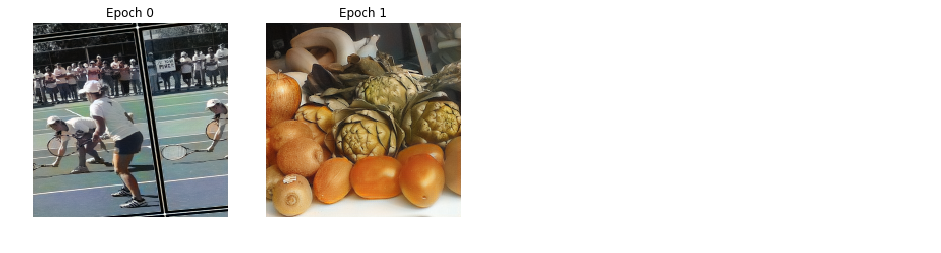

In [21]:
learn = refresh_gan('gan-128-10', bs=bs*2//3, size=192)
gc.collect()
learn.fit(2, lr)

In [22]:
learn.save('gan-192-2')

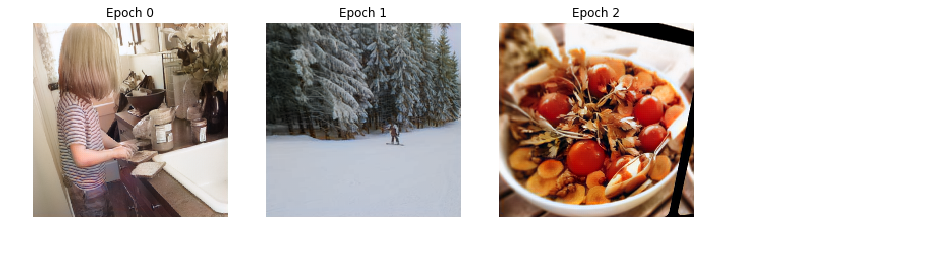

In [20]:
learn = refresh_gan('gan-192-2', bs=bs*2//3, size=192)
gc.collect()
learn.fit(3, lr)

In [21]:
learn.save('gan-192-5')

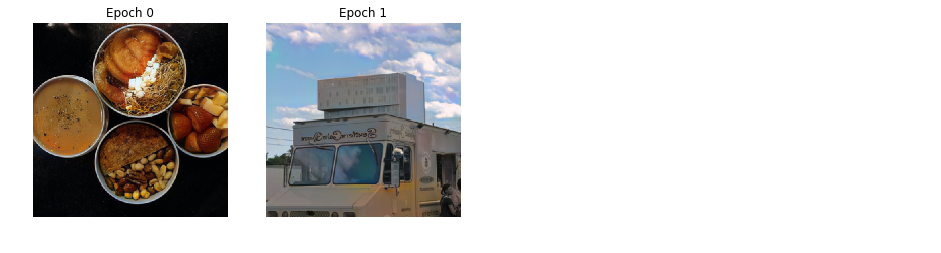

In [24]:
learn = refresh_gan('gan-192-5', bs=bs*2//3, size=192)
gc.collect()
learn.fit(2, lr)

In [25]:
learn.save('gan-192-7')

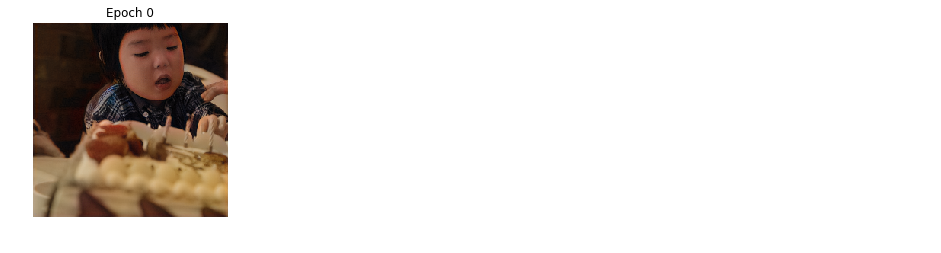

In [26]:
learn = refresh_gan('gan-192-5', bs=bs//3, size=256)
gc.collect()
learn.fit(1, lr/2)

In [27]:
learn.save('gan-256-1')

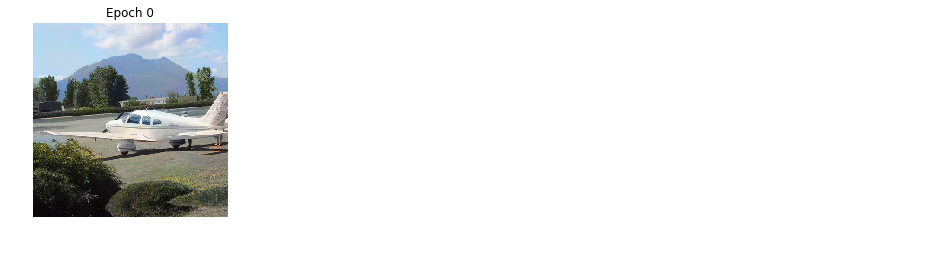

In [19]:
learn = refresh_gan('gan-256-1', bs=bs//3, size=256)
gc.collect()
learn.fit(1, lr/2)

In [20]:
learn.save('gan-256-2')

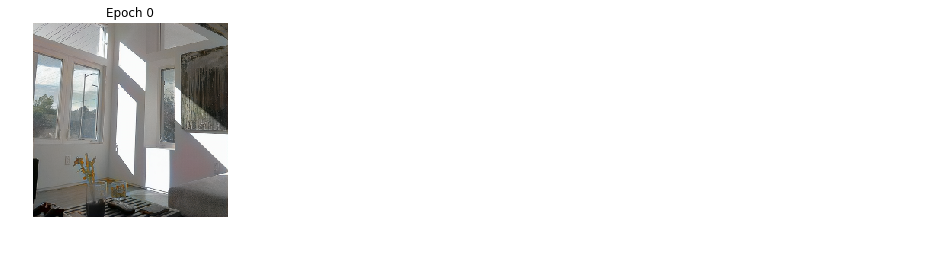

In [22]:
learn = refresh_gan('gan-256-2', bs=bs//3, size=256)
gc.collect()
learn.fit(1, lr/2)

In [23]:
learn.save('gan-256-3')

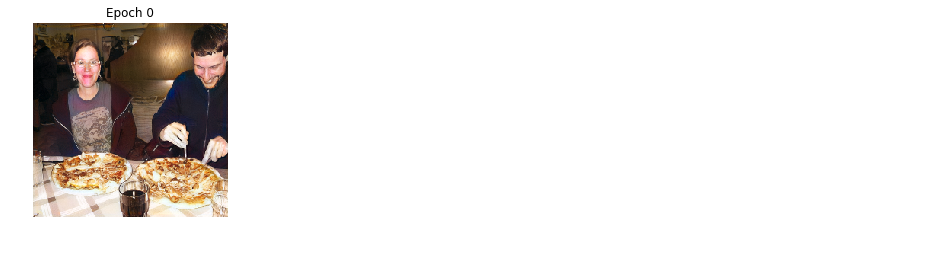

In [21]:
learn = refresh_gan('gan-256-3', bs=bs//3, size=256)
gc.collect()
learn.fit(1, lr/2)

In [22]:
learn.save('gan-256-4')

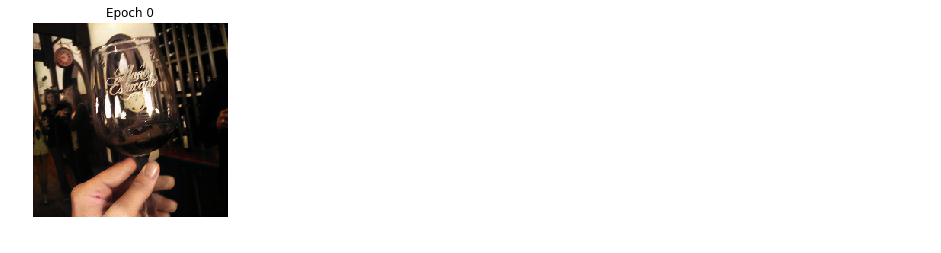

In [23]:
learn = refresh_gan('gan-256-4', bs=bs//3, size=256)
gc.collect()
learn.fit(1, lr/2)

In [24]:
learn.save('gan-256-5')

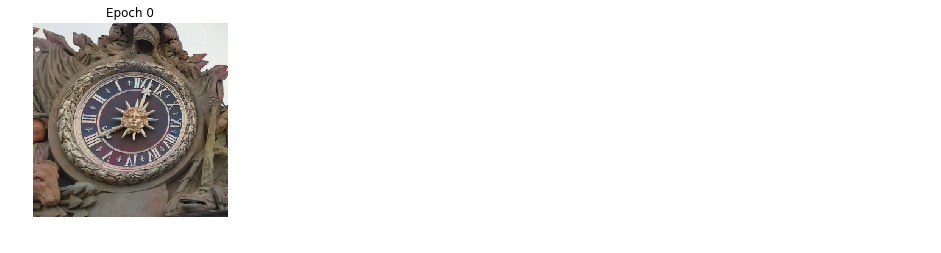

In [19]:
learn = refresh_gan('gan-256-5', bs=bs//5, size=320)
gc.collect()
learn.fit(1, lr/4)

In [20]:
learn.save('gan-320-1')

In [26]:
learn = refresh_gan('gan-320-1', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/4)

KeyboardInterrupt: 

In [ ]:
learn.save('gan-320-2')

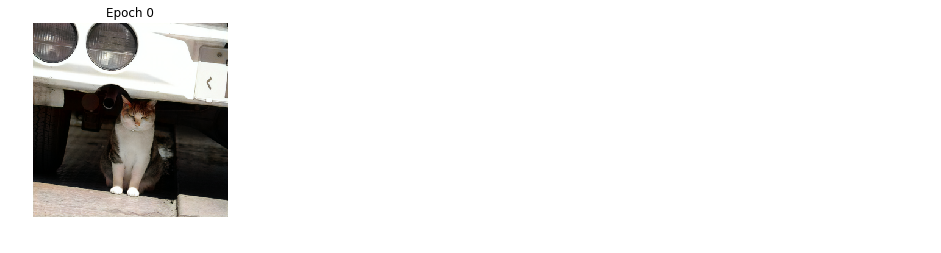

In [19]:
learn = refresh_gan('gan-320-2', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/4)

In [20]:
learn.save('gan-320-3')

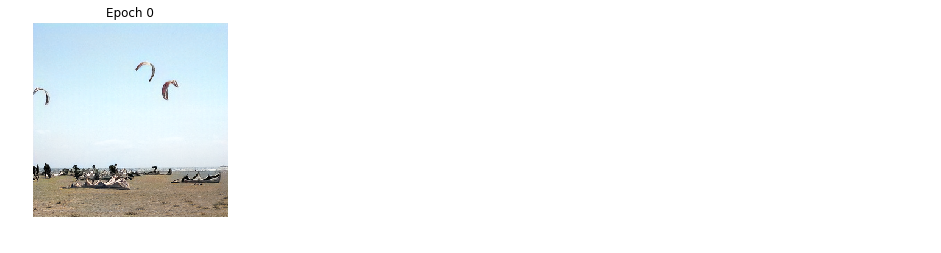

In [19]:
learn = refresh_gan('gan-320-3', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/4)

In [20]:
learn.save('gan-320-4')

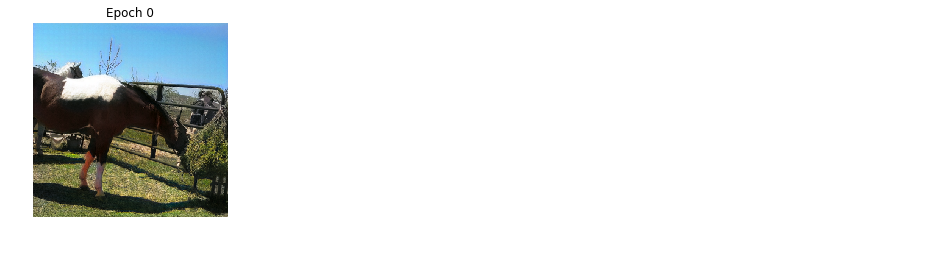

In [19]:
learn = refresh_gan('gan-320-4', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/4)

In [20]:
learn.save('gan-320-5')

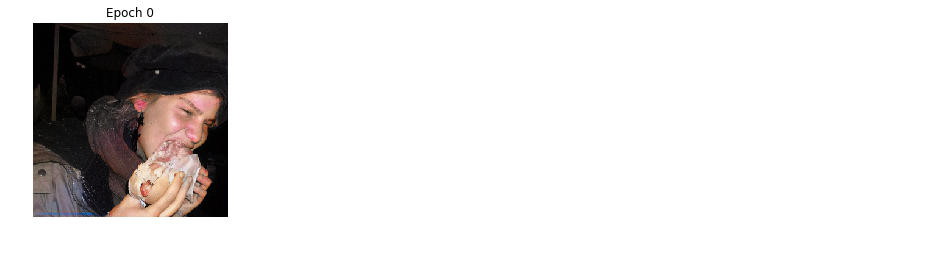

In [19]:
learn = refresh_gan('gan-320-5', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/8)

In [20]:
learn.save('gan-320-6')

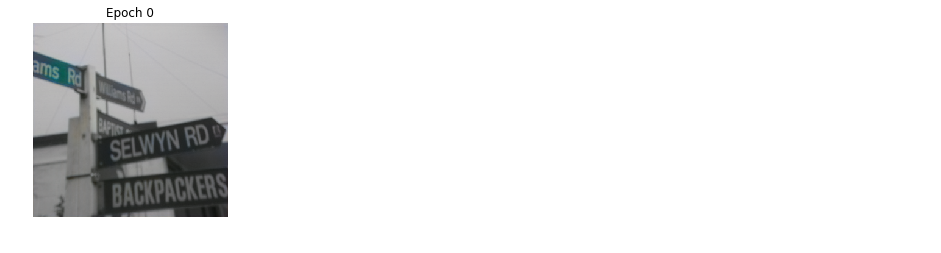

In [20]:
learn = refresh_gan('gan-320-6', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/8)

In [21]:
learn.save('gan-320-7')

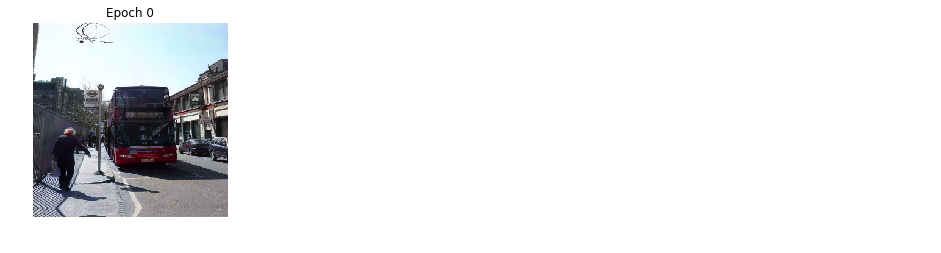

In [19]:
learn = refresh_gan('gan-320-7', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/8)

In [20]:
learn.save('gan-320-8')

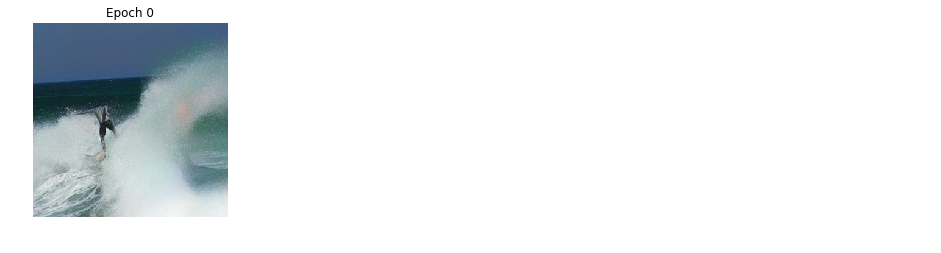

In [19]:
learn = refresh_gan('gan-320-8', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/8)

In [20]:
learn.save('gan-320-9')

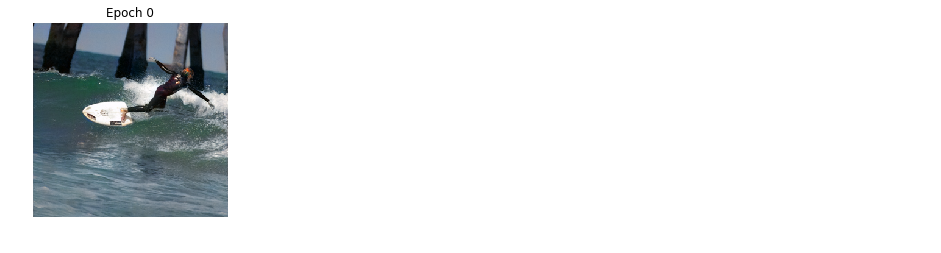

In [19]:
learn = refresh_gan('gan-320-9', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr/8)

In [ ]:
learn.save('gan-320-10')

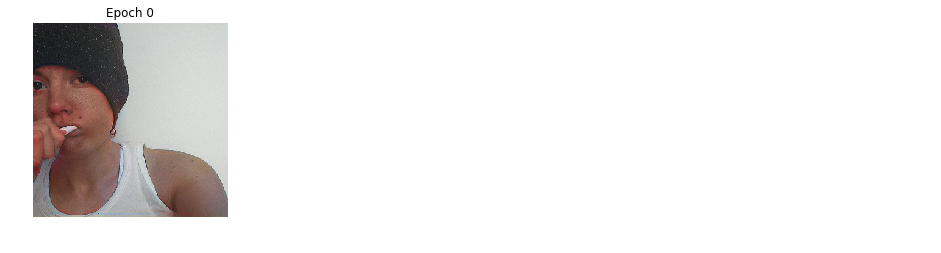

In [19]:
learn = refresh_gan('gan-320-10', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-11')

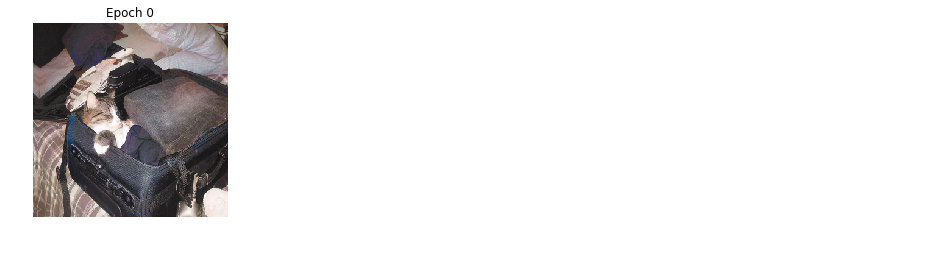

In [19]:
learn = refresh_gan('gan-320-11', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-12')

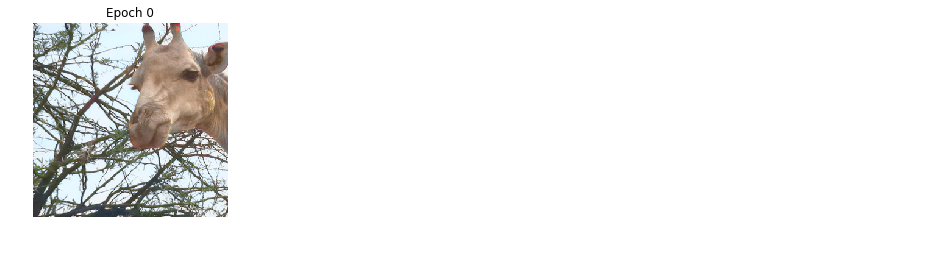

In [21]:
learn = refresh_gan('gan-320-12', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [22]:
learn.save('gan-320-13')

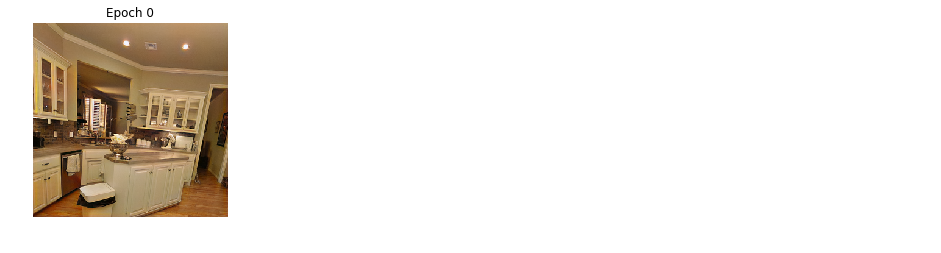

In [19]:
learn = refresh_gan('gan-320-13', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-14')

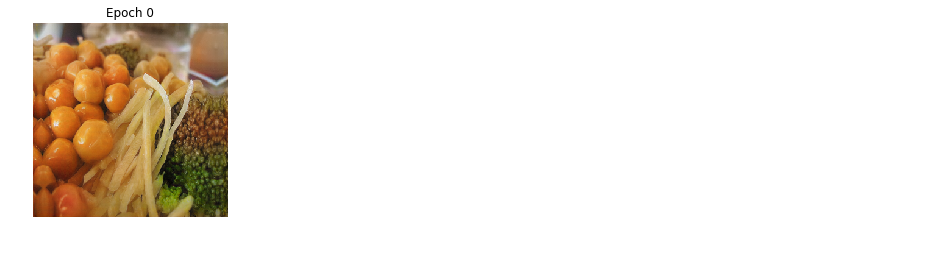

In [19]:
learn = refresh_gan('gan-320-14', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-15')

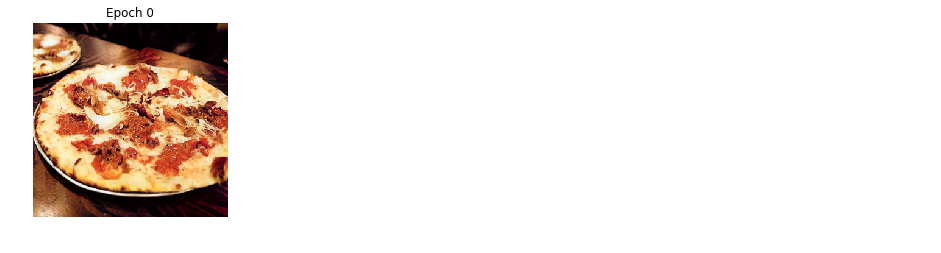

In [19]:
learn = refresh_gan('gan-320-15', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-16')

In [19]:
learn = refresh_gan('gan-320-16', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-17') # good results here

In [19]:
learn = refresh_gan('gan-320-17', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-18')

In [19]:
learn = refresh_gan('gan-320-18', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-19')

In [19]:
learn = refresh_gan('gan-320-19', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-20') #good results

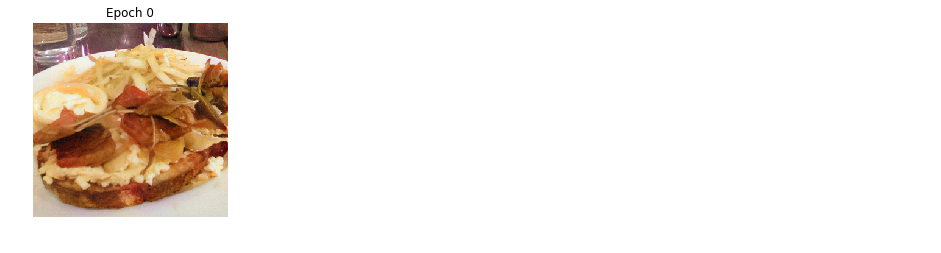

In [19]:
learn = refresh_gan('gan-320-20', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-21')

In [19]:
learn = refresh_gan('gan-320-21', bs=bs//6, size=320, p=0.4)
gc.collect()
learn.fit(3, lr)

In [20]:
learn.save('gan-320-22')

In [19]:
learn = refresh_gan('gan-320-22', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-23')

In [ ]:
learn = refresh_gan('gan-320-23', bs=bs//6, size=320, p=0.8)
gc.collect()
learn.fit(1, lr)

In [20]:
learn.save('gan-320-24') # pretty decent

In [25]:
learn.show_results(rows=6)

In [ ]:
learn = refresh_gan('gan-320-24', bs=6, size=320, p=0.2)

In [112]:
i = 20
open_image(path_color.ls()[i])

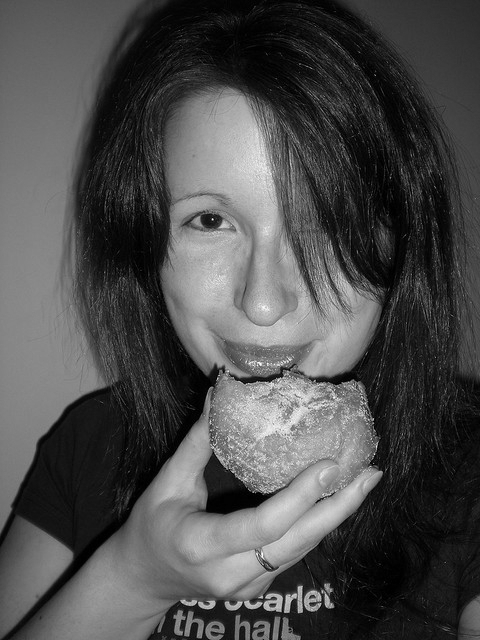

In [113]:
open_image(path_gray.ls()[i])

In [114]:
gray_img = open_image(path_gray.ls()[i])
learn.predict(gray_img)[0]

# Upload to DropBox

In [84]:
learn = refresh_gan('gan-320-24', bs=bs//6, size=320, p=0.8)
save_path = Path('/storage/capstone/colorizer')
fp = learn.save(save_path, return_path=True, with_opt=True) # pretty decent
fp = str(fp)

In [25]:
# export model
learn.export('colorizer.pkl')
fp = learn.path/'colorizer.pkl'

In [86]:
# modified solution found at: https://stackoverflow.com/questions/37397966/dropbox-api-v2-upload-large-files-using-python
def upload(access_token, file_path, target_path, timeout=900, chunk_size=4*1024*1024):
    dbx = dropbox.Dropbox(access_token, timeout=timeout)
    with open(file_path, "rb") as f:
        file_size = os.path.getsize(file_path)
        if file_size <= chunk_size:
            print(dbx.files_upload(f.read(), target_path))
        else:
            with tqdm(total=file_size, desc="Uploaded") as pbar:
                start_result = dbx.files_upload_session_start(f.read(chunk_size))
                pbar.update(chunk_size)
                cursor = dropbox.files.UploadSessionCursor(session_id=start_result.session_id, offset=f.tell())
                commit = dropbox.files.CommitInfo(path=target_path)
                while f.tell() < file_size:
                    if (file_size - f.tell()) <= chunk_size:
                        print(dbx.files_upload_session_finish(f.read(chunk_size), cursor, commit))
                    else:
                        dbx.files_upload_session_append(
                            f.read(chunk_size),
                            cursor.session_id,
                            cursor.offset,
                        )
                        cursor.offset = f.tell()
                    pbar.update(chunk_size)

In [87]:
key = "Wx9jfJEGYHsAAAAAAAAAU_4bjtXXeDSNPqylOcF_k6q4VB-lzxJ6vv_WPwxDVIQ2"
db_path = "/Apps/ImgBuff/colorizer.pth"
upload(key, fp, db_path)

Uploaded: 507510784it [01:36, 4987357.23it/s]                               

FileMetadata(name='colorizer.pth', id='id:V6kESqQ-glAAAAAAAAAAIA', client_modified=datetime.datetime(2020, 6, 22, 3, 8, 5), server_modified=datetime.datetime(2020, 6, 22, 3, 8, 5), rev='015a8a38d31783900000001d093aa70', size=506122862, path_lower='/apps/imgbuff/colorizer.pth', path_display='/Apps/ImgBuff/colorizer.pth', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='031cb54de6ece45e7842b7f79373f70ec4f0e230c26644b5ed0d2c819a55c2fd', file_lock_info=None)


In [42]:
gray = '/storage/capstone/grayscale/000000354235.jpg'
color = '/storage/capstone/color/000000354235.jpg'

In [43]:
key = "Wx9jfJEGYHsAAAAAAAAAU_4bjtXXeDSNPqylOcF_k6q4VB-lzxJ6vv_WPwxDVIQ2"
db_path = "/Apps/ImgBuff/grayscale/000000354235.jpg"
upload(key, gray, db_path)
db_path = "/Apps/ImgBuff/color/000000354235.jpg"
upload(key, color, db_path)

FileMetadata(name='000000354235.jpg', id='id:V6kESqQ-glAAAAAAAAAAGg', client_modified=datetime.datetime(2020, 6, 22, 1, 16, 50), server_modified=datetime.datetime(2020, 6, 22, 1, 16, 50), rev='015a8a1ff57fc0d00000001d093aa70', size=183867, path_lower='/apps/imgbuff/grayscale/000000354235.jpg', path_display='/Apps/ImgBuff/grayscale/000000354235.jpg', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='1d481cbbb22fba748a845f238539cd30ed45671287d74faf4776e0516dbb45f3', file_lock_info=None)
FileMetadata(name='000000354235.jpg', id='id:V6kESqQ-glAAAAAAAAAAGw', client_modified=datetime.datetime(2020, 6, 22, 1, 16, 52), server_modified=datetime.datetime(2020, 6, 22, 1, 16, 52), rev='015a8a1ff746fbf00000001d093aa70', size=203763, path_lower='/apps/imgbuff/color/000000354235.jpg', path_display='/Apps/ImgBuff/color/000000354235.jpg', parent_shared_folder_